In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import *

In [ ]:
pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Unins

In [ ]:

source = [0,0,1]
lamda = 100
ImageSize = 64
depthit = 10000
shadingit = 10000


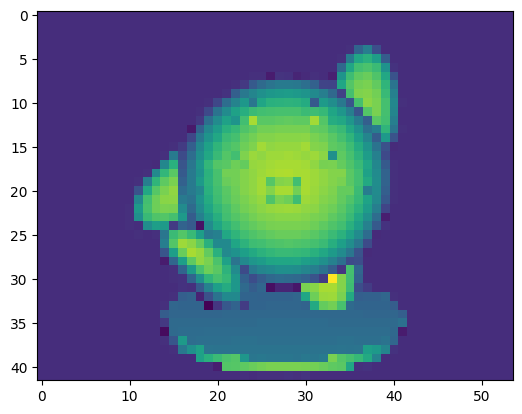

In [ ]:

inputImage = '/content/kirby.jpg'
rad = cv2.imread(inputImage)
rad = cv2.cvtColor(rad, cv2.COLOR_RGB2GRAY)
rad = cv2.resize(rad,None,fx=0.05,fy=0.05,interpolation=cv2.INTER_CUBIC)
radiance = np.asarray(rad)
plt.imshow(radiance)

regionOfInterest = radiance > 25
regionOfInterestRadiance = radiance > 25

boundaryMap              = np.zeros((ImageSize,ImageSize))
regionOfInterestRadiance = radiance > 0.8*47
kernel                   = np.ones((3,3),np.uint8)
boundaryMap              = regionOfInterestRadiance - cv2.erode(regionOfInterestRadiance.astype(np.uint8),kernel,5)
boundaryMap              = cv2.erode(cv2.dilate(boundaryMap.astype(np.uint8),kernel,3),kernel,3)
intersectionROI          = regionOfInterest * regionOfInterestRadiance

In [ ]:
print(np.mean(radiance))

47.28042328042328


In [ ]:

gradX, gradY       = np.array(radiance,copy=True),np.array(radiance,copy=True)
#gradX, gradY = np.zeros(depthMap.shape),np.zeros(depthMap.shape)
gradX[1:-1][:]     = (  gradX[:-2][:]  - gradX[2:][:] )
gradY[:][1:-1]     = (  gradY[:][2:]   - gradY[:][:-2])

pBoundary = np.array(gradX * boundaryMap.astype(bool),copy=True)
qBoundary = np.array(gradY * boundaryMap.astype(bool),copy=True)


In [ ]:
pBoundary.max()

255

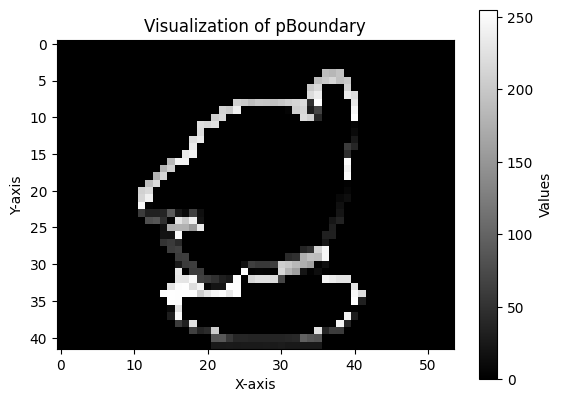

In [ ]:
# Plot the array
plt.imshow(pBoundary, cmap='gray', origin='upper')
plt.colorbar(label="Values")
plt.title("Visualization of pBoundary")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [109]:

p_next,q_next, p_estimated,q_estimated = deepcopy(pBoundary), deepcopy(qBoundary), deepcopy(pBoundary), deepcopy(qBoundary)

for t in tqdm(range(0,shadingit)):
	for i in range(1,pBoundary.shape[0]-1):
		for j in range(1,pBoundary.shape[1]-1):
			if regionOfInterestRadiance[i][j]:
				mod_s = (source[0]**2 + source[1]**2 + 1)**0.5
				mod_n = (p_estimated[i][j]**2 + q_estimated[i][j]**2 + 1)**0.5;
				radianc = (-p_estimated[i][j] * source[0] - q_estimated[i][j] * source[1] + 1) / ( mod_s *mod_n)
				RadianceX = (-source[0] - (q_estimated[i][j]**2)*source[0] + p_estimated[i][j]*q_estimated[i][j]*source[1] - p_estimated[i][j]*source[2])/(mod_s * mod_n**3)
				RadianceY = (-source[1] - (p_estimated[i][j]**2)*source[1] + p_estimated[i][j]*q_estimated[i][j]*source[0] - q_estimated[i][j]*source[2])/(mod_s * mod_n**3)
				p_next[i][j] = 0.25*(p_estimated[i-1][j] + p_estimated[i+1][j] + p_estimated[i][j-1] + p_estimated[i][j+1]) - 1/lamda *(E[i][j] - radianc)*RadianceX;
				q_next[i][j] = 0.25*(q_estimated[i-1][j] + q_estimated[i+1][j] + q_estimated[i][j-1] + q_estimated[i][j+1]) - 1/lamda *(E[i][j] - radianc)*RadianceX;
	p_estimated = (p_next*regionOfInterestRadiance*(1-boundaryMap.astype(bool))) + pBoundary*boundaryMap*regionOfInterestRadiance
	q_estimated = (q_next*regionOfInterestRadiance*(1-boundaryMap.astype(bool))) + qBoundary*boundaryMap*regionOfInterestRadiance


  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-109-f0e05ab47318>:25: RuntimeWarning: overflow encountered in scalar negative
  radianc = (-p_estimated[i][j] * source[0] - q_estimated[i][j] * source[1] + 1) / ( mod_s *mod_n)
<ipython-input-109-f0e05ab47318>:26: RuntimeWarning: overflow encountered in scalar multiply
  RadianceX = (-source[0] - (q_estimated[i][j]**2)*source[0] + p_estimated[i][j]*q_estimated[i][j]*source[1] - p_estimated[i][j]*source[2])/(mod_s * mod_n**3)
<ipython-input-109-f0e05ab47318>:27: RuntimeWarning: overflow encountered in scalar multiply
  RadianceY = (-source[1] - (p_estimated[i][j]**2)*source[1] + p_estimated[i][j]*q_estimated[i][j]*source[0] - q_estimated[i][j]*source[2])/(mod_s * mod_n**3)
<ipython-input-109-f0e05ab47318>:28: RuntimeWarning: overflow encountered in scalar add
  p_next[i][j] = 0.25*(p_estimated[i-1][j] + p_estimated[i+1][j] + p_estimated[i][j-1] + p_estimated[i][j+1]) - 1/lamda *(E[i][j] - radianc)*RadianceX;
<ipython-input-109-f0e05

In [115]:
temp   = np.zeros(p_estimated.shape)
Z     = np.zeros(p_estimated.shape)
p_x,q_y = np.array(p_estimated,copy=True),np.array(q_estimated,copy=True)

p_x[1:-1, :] = (p_estimated[2:, :] - p_estimated[:-2, :]) * 0.5
q_y[:, 1:-1] = (q_estimated[:, 2:] - q_estimated[:, :-2]) * 0.5

for iteration in range(0,depthit):
	for i in range(1,p_estimated.shape[0]-1):
		for j in range(1,p_estimated.shape[1]-1):
			if regionOfInterestRadiance[i][j] == 1 :
				Z[i][j] = 0.25*( temp[i-1][j] + temp[i+1][j] + temp[i][j-1] + temp[i][j+1]) + abs(p_x[i][j]) + abs(q_y[i][j])
	temp = regionOfInterestRadiance*Z;

Z_estimated = Z * regionOfInterestRadiance
Z_estimated = 100*Z_estimated/np.amax(Z_estimated)
print(np.amax(radiance))
print(np.amin(radiance))


151
6


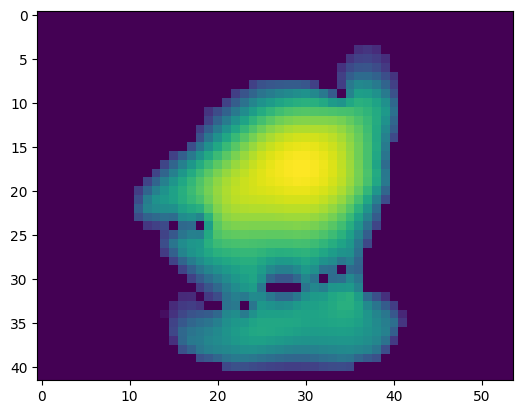

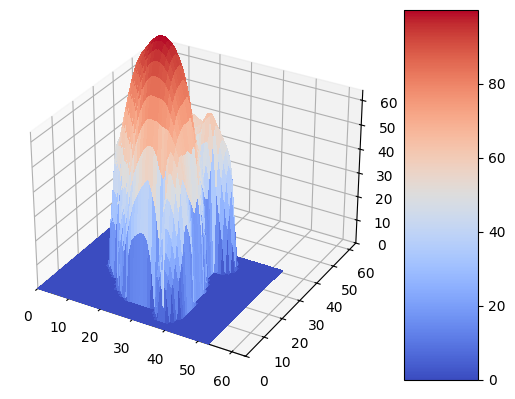

In [116]:
plt.imshow(Z_estimated)
plt.savefig('/content/nig.jpg')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(0,ImageSize)
ax.set_ylim3d(0,ImageSize)
ax.set_zlim3d(0,ImageSize)
[rows,cols] = np.meshgrid(range(0,rad.shape[1]),range(0,rad.shape[0]))
surf = ax.plot_surface(rows, cols, Z_estimated, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=1, aspect=5)
plt.show()

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming Z_estimated is a 2D array (depth map)
# Example Z_estimated for demonstration purposes (replace with actual data)

# Normalize Z_estimated to the range [0, 255] for grayscale conversion
Z_normalized = (Z_estimated - np.min(Z_estimated)) / (np.max(Z_estimated) - np.min(Z_estimated)) * 255
Z_normalized = Z_normalized.astype(np.uint8)

# Convert to grayscale image
image = Image.fromarray(Z_normalized, mode='L')
image.save('/content/Z_estimated_grayscale.jpg')



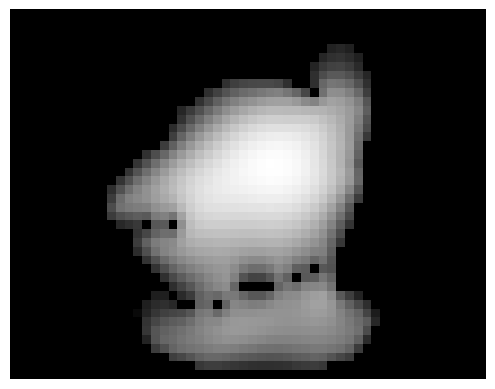

In [118]:

# Display image
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()

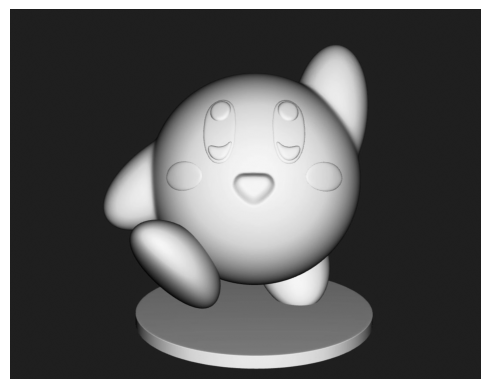

In [119]:
import imageio.v2 as imageio  # For reading images

# Load an image (Replace 'image.jpg' with your file path)
img = imageio.imread("kirby.jpg")

# Convert to grayscale if the image is RGB (3 channels)
if len(img.shape) == 3:
    img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale

# Display image
plt.imshow(img, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()